## Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [2]:
# Read the data from CSV file
df=pd.read_csv('./data/mental_health_data.csv')

In [3]:
# Count the number of posts from various subreddits
subreddit_counts = df['subreddit'].value_counts()
print(subreddit_counts)

subreddit
mentalhealth          999
Anxiety               998
BPD                   991
SuicideWatch          975
depression            912
CasualConversation    810
bipolar               554
Name: count, dtype: int64

In [4]:
# Check for missing values
na_values_count = df.isna().sum()
print(na_values_count)

Unnamed: 0        0
title             0
body            316
author           26
url               0
score             0
upvote_ratio      0
subreddit         0
dtype: int64

In [5]:
# Filter out rows where the 'body' column is null
null_body_rows = df[df['body'].isna()]
print(null_body_rows)

,Unnamed: 0,title,body,author,url,score,upvote_ratio,subreddit
11,11,LPT: Learn to distance yourself from your thou...,NaN,ChillingInChai,/r/LifeProTips/comments/n3loxq/lpt_learn_to_di...,2,1.00,mentalhealth
72,72,Lifelong neglect and abuse has led me unable t...,NaN,Ctantkeeper,/r/selfimprovement/comments/n3h3vv/lifelong_ne...,2,1.00,mentalhealth
213,213,Loving again,NaN,hrundiskel,/r/relationship_advice/comments/n3epx7/do_you_...,1,1.00,mentalhealth
255,255,"My mum is emotionally, verbally and at times p...",NaN,JackDoe1324,/r/domesticviolence/comments/n30v3n/my_mum_is_...,5,0.86,mentalhealth
260,260,I’m so scared,NaN,robsie123,/r/Paranoia/comments/n39e1m/im_so_scared/,1,1.00,mentalhealth
...,...,...,...,...,...,...,...,...
5312,5312,Is hanging the easiest and least painful way t...,NaN,PaceJust,https://www.reddit.com/r/SuicideWatch/comments...,2,1.00,SuicideWatch
5325,5325,I suffer from severe hyperacusis and Tinnitus....,NaN,Acceptable_Slide_667,https://www.reddit.com/r/SuicideWatch/comments...,3,1.00,SuicideWatch
5341,5341,My boyfriend of four years dumped me. My best ...,NaN,Ahunteriwillbe,https://www.reddit.com/r/SuicideWatch/comments...,3,0.80,SuicideWatch
5353,5353,My fiance is about to dump me,NaN,Throwaway2710383952,https://www.reddit.com/r/SuicideWatch/comments...,2,1.00,SuicideWatch


In [6]:
# Fill missing values with empty strings
df.fillna('', inplace=True)

# Combine 'title' and 'body' columns to create a new column 'full_text'
df['full_text'] = df['title'] + " " + df['body']

# Display the columns of the DataFrame
print(df.columns)

Index(['Unnamed: 0', 'title', 'body', 'author', 'url', 'score', 'upvote_ratio',
       'subreddit', 'full_text'],
      dtype='object')

In [7]:
# Group the posts based on author to check for multiple posts from the same author
author_group = df.groupby(['subreddit', 'author']).count()
print(author_group)

In [8]:
# Check authors with posts having high scores (Checking for popularity of posts)
authors_top_score = df[df['subreddit'] == "mentalhealth"].groupby(['author']).score.mean().sort_values(ascending=False)[:20].index
print(authors_top_score)

Index(['mothsandhoneydew', 'FelicityOfficial', 'hokeydokeydoo', 'Swappy-',
       'XX_mel_XX', 'AnonymousCounselor52', 'Busy-Chapter-2462',
       'Emotional-Treat-4523', 'imsorry_stillalive', 'Randumby194',
       'Far-Shape-4319', 'ConnecticutJohn', 'unit213x', 'Zeetrocheze',
       'starchild71', 'Critical_Shirt_2398', 'shootme_co', 'nsr-12309',
       'HelpPlease6537', 'Masculive'],
      dtype='object', name='author')

In [9]:
# Calculate the mean of scores for posts in the "mentalhealth" subreddit, grouped by author
mean_scores_mentalhealth = df[df['subreddit'] == "mentalhealth"].groupby(['author']).score.mean().sort_values(ascending=False)[:20]
print(mean_scores_mentalhealth)

author
mothsandhoneydew        669.0
FelicityOfficial        618.0
hokeydokeydoo           416.0
Swappy-                 406.0
XX_mel_XX               393.0
AnonymousCounselor52    387.0
Busy-Chapter-2462       296.0
Emotional-Treat-4523    240.0
imsorry_stillalive      189.0
Randumby194             152.0
Far-Shape-4319          130.0
ConnecticutJohn         112.0
unit213x                 69.0
Zeetrocheze              42.0
starchild71              39.0
Critical_Shirt_2398      37.0
shootme_co               36.0
nsr-12309                36.0
HelpPlease6537           28.0
Masculive                26.0
Name: score, dtype: float64

In [11]:
import re

def reddit_specific_preprocessing(text):
    # Remove newlines (one or more)
    text = re.sub(r'\n+', ' ', text)

    # Remove quotes
    text = re.sub(r'\"?\\?&?gt;?', '', text)

    # Remove asterisk
    text = re.sub(r'\*', '', text)

    # Remove bullet points
    text = re.sub('&amp;#x200B;', '', text)

    # Remove links (always enclosed between parenthesis)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    # Remove strikethroughs
    text = re.sub('~', '', text)

    # Remove spoilers, which are used with < less-than (Preserves the text)
    text = re.sub('&lt;', '', text)
    text = re.sub(r'!(.*?)!', r'\1', text)

    # Code, inline and block
    text = re.sub('`', '', text)

    # Superscript (Preserves the text)
    text = re.sub(r'\^\((.*?)\)', r'\1', text)

    # Table
    text = re.sub(r'\|', ' ', text)
    text = re.sub(':-', '', text)

    # Heading
    text = re.sub('#', '', text)

    # Clean white spaces
    text = text.strip()
    text = re.sub(r'\s\s+', ' ', text)

    return text

In [12]:
df

,Unnamed: 0,title,body,author,url,score,upvote_ratio,subreddit,full_text
0,0,Craving closeness,"About a year ago, I got into a relationship th...",Nash4N00b,https://www.reddit.com/r/mentalhealth/comments...,2,1.00,mentalhealth,"Craving closeness About a year ago, I got into..."
1,1,Mental health class,I think schools should have a mandatory mental...,ConnecticutJohn,https://www.reddit.com/r/mentalhealth/comments...,112,0.97,mentalhealth,Mental health class I think schools should hav...
2,2,My 7yo son accidentally fell on our pet bird a...,It was TRULY a freak accident and not expected...,AnonymousCounselor52,https://www.reddit.com/r/mentalhealth/comments...,387,0.97,mentalhealth,My 7yo son accidentally fell on our pet bird a...
3,3,Who else doesn’t want covid world to leave,My mental health has been so bad and I’ve been...,jjdabest8820,https://www.reddit.com/r/mentalhealth/comments...,15,0.94,mentalhealth,Who else doesn’t want covid world to leave My ...
4,4,my mental health is suffering due to my contro...,note: please read my previous posts for contex...,Wooden_View_7120,https://www.reddit.com/r/mentalhealth/comments...,7,0.83,mentalhealth,my mental health is suffering due to my contro...
...,...,...,...,...,...,...,...,...,...
6234,6234,Gave my 4 year old stepson an empty box to pla...,We just got some packages delivered and one wa...,Hatecookie,https://www.reddit.com/r/CasualConversation/co...,10,1.00,CasualConversation,Gave my 4 year old stepson an empty box to pla...
6235,6235,I just realized that I'm not funny anymore,For my whole life people would always say that...,SirHovaOfBrooklyn,https://www.reddit.com/r/CasualConversation/co...,10,1.00,CasualConversation,I just realized that I'm not funny anymore For...
6236,6236,Am I the only one that finds the words “best f...,I used to call that to my friends back then wh...,Anonymous_12740,https://www.reddit.com/r/CasualConversation/co...,2,0.75,CasualConversation,Am I the only one that finds the words “best f...
6237,6237,Anyone else has a big fear to physical pain,"I mean, sure, we all fear physical pain and we...",ganimede_s,https://www.reddit.com/r/CasualConversation/co...,6,0.80,CasualConversation,Anyone else has a big fear to physical pain I ...


In [15]:
# Prepare a subset of the data and store it in a new dataframe
df_preprocessing = df[["subreddit", 'url', 'full_text']].copy()

# Apply Reddit specific preprocessing
df_preprocessing['01_reddit_specific'] = df_preprocessing['full_text'].apply(lambda text: reddit_specific_preprocessing(text))

# Print out a message
print(df_preprocessing['01_reddit_specific'][0])

'Craving closeness About a year ago, I got into a relationship that lasted until December 2020. I was the one that broke up. I loved her, but I didn’t see a satisfying future for me, so it was a tough decision to make. The problem is that I now really crave the closeness I had with her, cause I don’t really get that with anyone else. I want the love we had for each other with someone else, and it’s really annoying. I want the spooning, the sex, everything. I’m only 18, so it’s probably not something I should be thinking about, but I do. Is this normal, or should I seek help?'

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import nltk

nltk.download('wordnet')

def clean_message(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        messages_cleaned: a list of words containing the processed message. 
    '''

    stem = PorterStemmer()
    lemma = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    messages_cleaned = []
    message = word_tokenize(message)

    for i in message:
        if i.lower() not in stop_words and i.isalnum():
            messages_cleaned.append(re.sub(r'http\S+', '', lemma.lemmatize(i.lower())))
    
    return " ".join(messages_cleaned)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ameyagidh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
# Applying the clean_message function to the text
df_preprocessing['cleaned_text'] = df_preprocessing["01_reddit_specific"].apply(clean_message)

# Displaying the DataFrame
print(df_preprocessing)

,Unnamed: 0,title,body,author,url,score,upvote_ratio,subreddit,full_text
0,0,Craving closeness,"About a year ago, I got into a relationship th...",Nash4N00b,https://www.reddit.com/r/mentalhealth/comments...,2,1.00,mentalhealth,"Craving closeness About a year ago, I got into..."
1,1,Mental health class,I think schools should have a mandatory mental...,ConnecticutJohn,https://www.reddit.com/r/mentalhealth/comments...,112,0.97,mentalhealth,Mental health class I think schools should hav...
2,2,My 7yo son accidentally fell on our pet bird a...,It was TRULY a freak accident and not expected...,AnonymousCounselor52,https://www.reddit.com/r/mentalhealth/comments...,387,0.97,mentalhealth,My 7yo son accidentally fell on our pet bird a...
3,3,Who else doesn’t want covid world to leave,My mental health has been so bad and I’ve been...,jjdabest8820,https://www.reddit.com/r/mentalhealth/comments...,15,0.94,mentalhealth,Who else doesn’t want covid world to leave My ...
4,4,my mental health is suffering due to my contro...,note: please read my previous posts for contex...,Wooden_View_7120,https://www.reddit.com/r/mentalhealth/comments...,7,0.83,mentalhealth,my mental health is suffering due to my contro...
...,...,...,...,...,...,...,...,...,...
6234,6234,Gave my 4 year old stepson an empty box to pla...,We just got some packages delivered and one wa...,Hatecookie,https://www.reddit.com/r/CasualConversation/co...,10,1.00,CasualConversation,Gave my 4 year old stepson an empty box to pla...
6235,6235,I just realized that I'm not funny anymore,For my whole life people would always say that...,SirHovaOfBrooklyn,https://www.reddit.com/r/CasualConversation/co...,10,1.00,CasualConversation,I just realized that I'm not funny anymore For...
6236,6236,Am I the only one that finds the words “best f...,I used to call that to my friends back then wh...,Anonymous_12740,https://www.reddit.com/r/CasualConversation/co...,2,0.75,CasualConversation,Am I the only one that finds the words “best f...
6237,6237,Anyone else has a big fear to physical pain,"I mean, sure, we all fear physical pain and we...",ganimede_s,https://www.reddit.com/r/CasualConversation/co...,6,0.80,CasualConversation,Anyone else has a big fear to physical pain I ...


In [21]:
import langdetect

language_counts = []
for i in range(len(df_preprocessing)):
    try:
        language_counts.append(langdetect.detect(df_preprocessing["cleaned_text"].iloc[i]))
    except:
        pass


In [22]:
# Initialize count and index variables
count = 0
index = []

# Iterate through the language detection results
for i in range(len(language_counts)):
    # Check if the language detected is English
    if language_counts[i] == 'en':
        # If English, append the index to the index list and increment count
        index.append(i)
        count += 1
    else:
        pass  # Skip non-English languages


In [26]:
# Keeping only posts in English
df_english = df_preprocessing.iloc[index]

# Selecting required columns
df = df_english[["subreddit", "url", "cleaned_text"]]

# Saving the preprocessed data to a CSV file
df.to_csv('./data/data_preprocessed.csv', index=False)

## Vectorizing the posts

In [27]:
# Vectorizing the posts using Count Vectorizer and TFidf Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Instantiate CountVectorizer
cv = CountVectorizer()

# Instantiate TfidfVectorizer
tfidf = TfidfVectorizer()

# Transform the text data using CountVectorizer
X_cv = cv.fit_transform(df['cleaned_text'])

# Transform the text data using TfidfVectorizer
X_tfidf = tfidf.fit_transform(df['cleaned_text'])

In [28]:
# Count the number of posts from each subreddit
subreddit_counts = df['subreddit'].value_counts()
print(subreddit_counts)

subreddit
Anxiety               989
BPD                   988
mentalhealth          987
SuicideWatch          926
depression            902
CasualConversation    800
bipolar               477
Name: count, dtype: int64

In [30]:
# Storing a list of tokens
df["list"] = df["cleaned_text"].str.split(" ")
# Giving labels to the subreddit column
df['subreddit_labels'] = df['subreddit'].map({'BPD': 0, 'mentalhealth': 1, "Anxiety": 2, "SuicideWatch": 3, "depression": 4, "CasualConversation": 5, "bipolar": 6})

# Instantiate CountVectorizer
cv = CountVectorizer()

# Instantiate TfidfVectorizer
tfidf = TfidfVectorizer()

# Transform the text data using CountVectorizer
X_cv = cv.fit_transform(df['cleaned_text'])

# Transform the text data using TfidfVectorizer
X_tfidf = tfidf.fit_transform(df['cleaned_text'])

# Convert the TF-IDF matrix to an array
X_tfidf_array = X_tfidf.toarray()

# Define the target variable
y = df["subreddit_labels"]

/var/folders/b_/qpl3sp4n7_55mr2n2w20rmh40000gn/T/ipykernel_2288/4268500046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["list"] = df["cleaned_text"].str.split(" ")


In [36]:
X_cv.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Gaussian Naive Bayes

In [38]:
# Implementing Gaussian Naive Bayes model to predict target labels
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Instantiate Gaussian Naive Bayes model
model_nb = GaussianNB()

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cv.toarray(), y)

# Fitting the model on the training data
model_nb.fit(X_train, y_train)

# Predicting on the test data
y_pred_n = model_nb.predict(X_test)

# Calculating accuracy score
print(accuracy_score(y_pred_n, y_test))

0.2977602108036891


## Multinomial Naive Bayes

In [39]:
# Implementing Multinomial Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Instantiate Multinomial Naive Bayes model
model = MultinomialNB()

# Convert NaN values to 0
X = np.nan_to_num(X_tfidf)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate accuracy score
print(accuracy_score(y_pred, y_test))

0.4189723320158103


## Logistic Regression

In [40]:
# Implementing logistic regression
from sklearn.linear_model import LogisticRegression

# Instantiate logistic regression model
linear_model = LogisticRegression()

# Fit the model on the training data
linear_model.fit(X_train, y_train)

# Predict on the test data
y_pred = linear_model.predict(X_test)

# Calculate accuracy score
print(accuracy_score(y_pred, y_test))

0.5876152832674572


## Word2Vec

In [42]:
# Implementing Word2vec as the previous methods were not helpful in capturing the context of the posts.
# The accuracy of the model was also pretty low.
import gensim
from gensim.models import Word2Vec

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'].str.split(" "), y)

# Train Word2Vec model
word2vec = Word2Vec(df['cleaned_text'].str.split(" "))

# Get normalized word vectors
vectors = word2vec.wv.get_normed_vectors()

# Get set of words in the vocabulary
words = set(word2vec.wv.index_to_key)

# Convert text data into word vectors
X_train_vect = np.array([np.array([word2vec.wv[i] for i in ls if i in words]) for ls in X_train])
X_test_vect = np.array([np.array([word2vec.wv[i] for i in ls if i in words]) for ls in X_test])

# Calculate average word vectors for each post in the training set
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

# Calculate average word vectors for each post in the testing set
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))
# Get set of words in the vocabulary
words = set(word2vec.wv.index_to_key)

# Convert text data into word vectors
X_train_vect = np.array([np.array([word2vec.wv[i] for i in ls if i in words]) for ls in X_train])
X_test_vect = np.array([np.array([word2vec.wv[i] for i in ls if i in words]) for ls in X_test])

# Calculate average word vectors for each post in the training set
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

# Calculate average word vectors for each post in the testing set
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

X_train_vect_avg = []
for v in X_train_vect:
    # Check if the word vector is non-empty
    if v.size:
        # Calculate the average word vector for the post
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        # If the word vector is empty, append a zero vector of appropriate dimensions
        X_train_vect_avg.append(np.zeros(100, dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    # Check if the word vector is non-empty
    if v.size:
        # Calculate the average word vector for the post
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        # If the word vector is empty, append a zero vector of appropriate dimensions
        X_test_vect_avg.append(np.zeros(100, dtype=float))


/var/folders/b_/qpl3sp4n7_55mr2n2w20rmh40000gn/T/ipykernel_2288/871207453.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([word2vec.wv[i] for i in ls if i in words])
/var/folders/b_/qpl3sp4n7_55mr2n2w20rmh40000gn/T/ipykernel_2288/871207453.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([word2vec.wv[i] for i in ls if i in words])


## Random Forest

In [45]:
# Implementing Random Forest Classifier on the Word2Vec embedding
from sklearn.ensemble import RandomForestClassifier

# Instantiate Random Forest Classifier
rf = RandomForestClassifier()

# Fit the model on the training data
rf.fit(X_train_vect_avg, y_train)

# Predict on the test data
y_pred = rf.predict(X_test_vect_avg)

# Calculate accuracy score
print(accuracy_score(y_pred, y_test))

0.3952569169960474


In [46]:
# Implementing Logistic Regression on the Word2Vec embedding
from sklearn.linear_model import LogisticRegression

# Instantiate Logistic Regression model
linear_model = LogisticRegression()

# Fit the model on the training data
linear_model.fit(X_train_vect_avg, y_train)

# Predict on the test data
y_pred = linear_model.predict(X_test_vect_avg)

# Calculate accuracy score
print(accuracy_score(y_pred, y_test))

0.461133069828722


/opt/homebrew/anaconda3/envs/ameya/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## TSNE

In [47]:
# Implementing TSNE to visualize the Word2Vec embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne_plot(model):
    "Creates a TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
    plt.show()
sid = SentimentIntensityAnalyzer()

In [50]:
# Implementing a function to calculate polarity scores given a post
def get_polarity(text):
    return sid.polarity_scores(text)['compound']

# Apply the function to calculate polarity scores for each post and store the result in a new column
df['polarity_score'] = df['cleaned_text'].apply(get_polarity)

<Axes: xlabel='subreddit'>

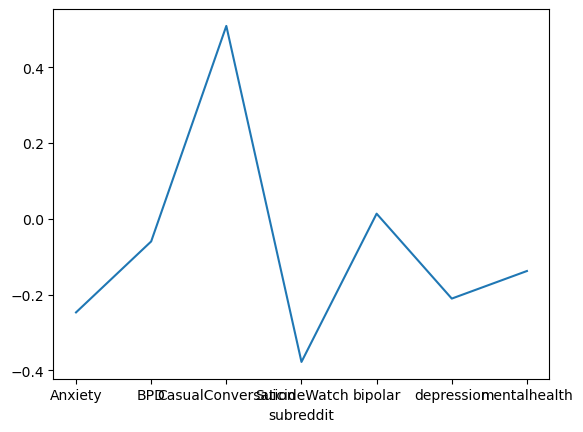

In [52]:
# Plotting the mean polarity scores among various subreddits
df.groupby('subreddit').polarity_score.mean().plot()

In [53]:
# Calculating the mean polarity scores among various subreddits
mean_polarity_scores = df.groupby('subreddit').polarity_score.mean()

# Mean polarity scores for specific subreddits
print("Mean polarity score for 'CasualConversation':", mean_polarity_scores['CasualConversation'])
print("Mean polarity score for 'SuicideWatch':", mean_polarity_scores['SuicideWatch'])
print("Mean polarity score for 'Anxiety':", mean_polarity_scores['Anxiety'])

subreddit
Anxiety              -0.246940
BPD                  -0.059719
CasualConversation    0.508827
SuicideWatch         -0.377561
bipolar               0.013539
depression           -0.210473
mentalhealth         -0.137737
Name: polarity_score, dtype: float64

In [54]:
# Returning the number of unique elements in each subreddit
for subreddit in df['subreddit'].unique():    
    print("{}: {}".format(subreddit, len(df[df['subreddit'] == subreddit])))
# Removing posts from the 'bipolar' subreddit
df = df[df['subreddit'] != "bipolar"]

mentalhealth: 987
depression: 902
Anxiety: 989
bipolar: 477
BPD: 988
SuicideWatch: 926
CasualConversation: 800


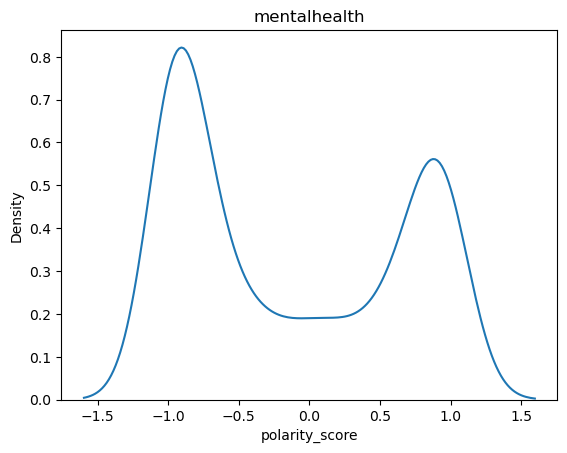

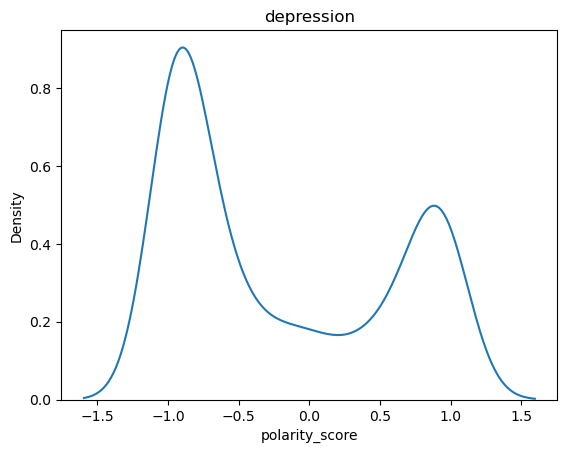

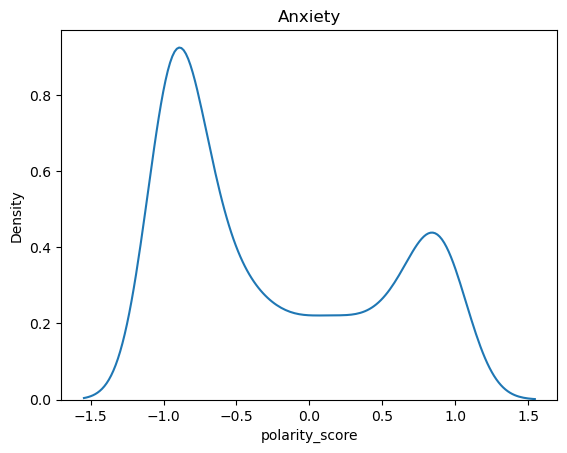

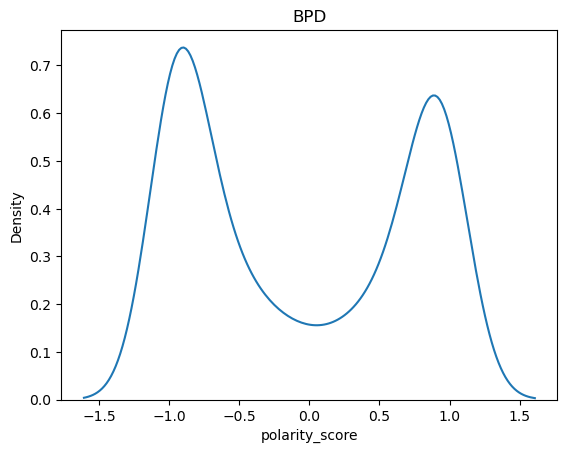

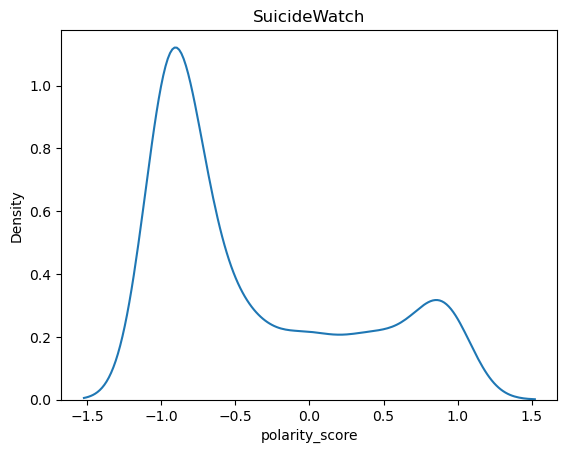

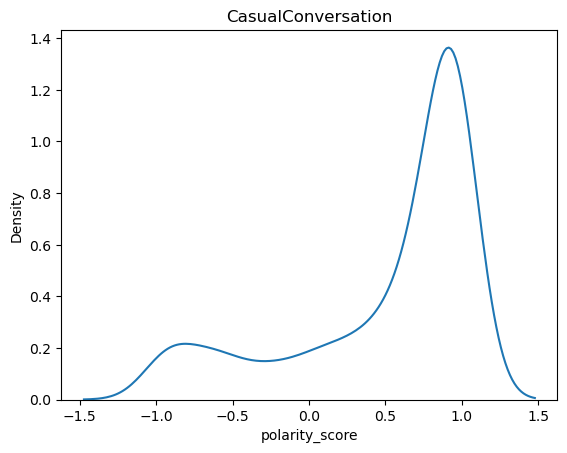

In [56]:
# Plotting the polarity scores for various subreddits
import matplotlib.pyplot as plt
import seaborn as sns

# Iterate over unique subreddits
j = 1
for subreddit in df['subreddit'].unique():
    plt.figure(j)
    sns.kdeplot(df[df['subreddit'] == subreddit]['polarity_score'])
    plt.title(subreddit)
    j += 1

In [ ]:
get_polarity("hello I'm feeling sad")  # For posts related to feeling sad, it might have negative polarity.

get_polarity("I'm dying")  # For posts expressing extreme distress like "I'm dying", it's likely to have a very negative polarity.

# Function to return a label predicting which subreddit the given sentence might belong to
def get_severity(text):
    from scipy.stats import gaussian_kde
    
    severity = ""
    max_severity = float("-inf")
    
    # Iterate through unique subreddits
    for subreddit in df.subreddit.unique():
        # Calculate kernel density estimation for the polarity scores of the subreddit
        kde = gaussian_kde(df[df['subreddit'] == subreddit]['polarity_score'].values)
        # Evaluate the severity of the given text based on the KDE
        sev = kde.evaluate([get_polarity(text)])
        
        # Update severity label if higher severity is found
        if sev > max_severity:
            severity = subreddit
            max_severity = sev
            
    return severity

In [60]:
# Testing with a sample sentence
get_severity("I'm Happy now")

# Filter posts from specific subreddits
filtered = df[df['subreddit'].isin(['CasualConversation', 'depression', 'SuicideWatch'])]

'CasualConversation'

In [62]:
# Calculate the mean polarity score for each subreddit in the filtered DataFrame
filtered.groupby('subreddit').polarity_score.mean()

subreddit
CasualConversation    0.508827
SuicideWatch         -0.377561
depression           -0.210473
Name: polarity_score, dtype: float64

In [63]:
# Implementing Logistic regression on cleaned text improved the results significantly
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TF-IDF Vectorizer
tfidf = TfidfVectorizer()

# Convert text data into TF-IDF vectors
X = tfidf.fit_transform(filtered['cleaned_text'])
y = filtered["subreddit_labels"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, filtered["subreddit_labels"])

# Iterate through different values of C for Logistic Regression
for c_value in [0.01, 0.1, 0.5, 1, 2, 3, 4, 5]:
    # Instantiate Logistic Regression model with specified C value
    model = LogisticRegression(C=c_value)
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Print the accuracy score for the current C value
    print(f"C-value {c_value} and accuracy : {accuracy_score(y_pred, y_test)}")

C-value 0.01 and accuracy : 0.3333333333333333
C-value 0.1 and accuracy : 0.7092846270928462
C-value 0.5 and accuracy : 0.7123287671232876
C-value 1 and accuracy : 0.7047184170471842
C-value 2 and accuracy : 0.6925418569254186
C-value 3 and accuracy : 0.6940639269406392
C-value 4 and accuracy : 0.6971080669710806
C-value 5 and accuracy : 0.6894977168949772


/opt/homebrew/anaconda3/envs/ameya/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Support Vector Classifier

In [64]:
# Implementing Support Vector Classifier
from sklearn.svm import SVC

# Iterate through different values of C for Support Vector Classifier
for c_value in [0.01, 0.1, 0.5, 1, 2, 3, 4, 5]:
    # Instantiate Support Vector Classifier with specified C value
    model = SVC(C=c_value)
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Print the accuracy score for the current C value
    print(f"C - Value: {c_value} and accuracy : {accuracy_score(y_pred, y_test)}")

C - Value: 0.01 and accuracy : 0.3226788432267884
C - Value: 0.1 and accuracy : 0.3226788432267884
C - Value: 0.5 and accuracy : 0.7092846270928462
C - Value: 1 and accuracy : 0.715372907153729
C - Value: 2 and accuracy : 0.6986301369863014
C - Value: 3 and accuracy : 0.700152207001522
C - Value: 4 and accuracy : 0.6971080669710806
C - Value: 5 and accuracy : 0.69558599695586


In [65]:
# Implementing Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Iterate through different values of n_estimators for Random Forest Classifier
for n_estimators_value in [100, 200, 300, 400, 500, 1000]:
    # Instantiate Random Forest Classifier with specified n_estimators value
    model = RandomForestClassifier(n_estimators=n_estimators_value)
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Print the accuracy score for the current n_estimators value
    print(f"N-Estimators: {n_estimators_value} and accuracy : {accuracy_score(y_pred, y_test)}")

N-Estimators: 100 and accuracy : 0.6986301369863014
N-Estimators: 200 and accuracy : 0.7336377473363774
N-Estimators: 300 and accuracy : 0.7427701674277016
N-Estimators: 400 and accuracy : 0.7214611872146118
N-Estimators: 500 and accuracy : 0.7290715372907154
N-Estimators: 1000 and accuracy : 0.7275494672754946


In [66]:
# Printing out the Classification report for the Random Forest Model
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           3       0.82      0.60      0.70       288
           4       0.54      0.73      0.62       172
           5       0.84      0.91      0.87       197

    accuracy                           0.73       657
   macro avg       0.73      0.75      0.73       657
weighted avg       0.75      0.73      0.73       657



In [67]:
# Performing Train-test split
y = filtered["subreddit_labels"]
X_train, X_test, y_train, y_test = train_test_split(filtered['cleaned_text'].str.split(" "), y)
# Loading the pre-processed data which was stored in a csv file
df = pd.read_csv("data_preprocessed.csv")

In [69]:
df.columns

Index(['Unnamed: 0', 'subreddit', 'url', 'cleaned_text'], dtype='object')

In [70]:
topics = []
for i in range(len(df)):
    if len(df["url"].iloc[i].split("/")) > 4:
        topics.append(df["url"].iloc[i].split("/")[4])
    else:
        topics.append(df["url"].iloc[i].split("/")[2])

In [72]:
df["Topics"] = topics
df

,Unnamed: 0,subreddit,url,cleaned_text,Topics
0,0,mentalhealth,https://www.reddit.com/r/mentalhealth/comments...,craving closeness year ago got relationship la...,mentalhealth
1,1,mentalhealth,https://www.reddit.com/r/mentalhealth/comments...,mental health class think school mandatory men...,mentalhealth
2,2,mentalhealth,https://www.reddit.com/r/mentalhealth/comments...,7yo son accidentally fell pet bird killed 11 y...,mentalhealth
3,3,mentalhealth,https://www.reddit.com/r/mentalhealth/comments...,else want covid world leave mental health bad ...,mentalhealth
4,4,mentalhealth,https://www.reddit.com/r/mentalhealth/comments...,mental health suffering due controlling toxic ...,mentalhealth
...,...,...,...,...,...
6064,6229,CasualConversation,https://www.reddit.com/r/CasualConversation/co...,teacher problem accidentally text parent child...,CasualConversation
6065,6230,CasualConversation,https://www.reddit.com/r/CasualConversation/co...,painted nail feel weird distracting got done f...,CasualConversation
6066,6231,CasualConversation,https://www.reddit.com/r/CasualConversation/co...,first time watching traininy day never seen al...,CasualConversation
6067,6232,CasualConversation,https://www.reddit.com/r/CasualConversation/co...,taking bra night wear one day best feeling eve...,CasualConversation


In [73]:
df

,Unnamed: 0,subreddit,url,cleaned_text,Topics
0,0,mentalhealth,https://www.reddit.com/r/mentalhealth/comments...,craving closeness year ago got relationship la...,mentalhealth
1,1,mentalhealth,https://www.reddit.com/r/mentalhealth/comments...,mental health class think school mandatory men...,mentalhealth
2,2,mentalhealth,https://www.reddit.com/r/mentalhealth/comments...,7yo son accidentally fell pet bird killed 11 y...,mentalhealth
3,3,mentalhealth,https://www.reddit.com/r/mentalhealth/comments...,else want covid world leave mental health bad ...,mentalhealth
4,4,mentalhealth,https://www.reddit.com/r/mentalhealth/comments...,mental health suffering due controlling toxic ...,mentalhealth
...,...,...,...,...,...
6064,6229,CasualConversation,https://www.reddit.com/r/CasualConversation/co...,teacher problem accidentally text parent child...,CasualConversation
6065,6230,CasualConversation,https://www.reddit.com/r/CasualConversation/co...,painted nail feel weird distracting got done f...,CasualConversation
6066,6231,CasualConversation,https://www.reddit.com/r/CasualConversation/co...,first time watching traininy day never seen al...,CasualConversation
6067,6232,CasualConversation,https://www.reddit.com/r/CasualConversation/co...,taking bra night wear one day best feeling eve...,CasualConversation


In [76]:
# Drop the 'Unnamed: 0' column
df = df.drop(columns=["Unnamed: 0"])

# Extract the 'cleaned_text' column for further processing
df_req = df["cleaned_text"]

print(df_req.isnull().sum())

# Drop rows with missing values in the 'cleaned_text' column
df_req = df_req.dropna()

5

In [113]:
# Forming bigrams from the sentence for further analysis
import gensim

def bigrams(words, bi_min=15, tri_min=10):
    """
    Form bigrams from a list of words.

    Args:
    words (list): List of words.
    bi_min (int): Minimum frequency threshold for bigrams.
    tri_min (int): Minimum frequency threshold for trigrams.

    Returns:
    gensim.models.phrases.Phraser: Bigram model.
    """
    bigram = gensim.models.Phrases(words, min_count=bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def sent_to_words(sentences):
    """
    Tokenize sentences into words.

    Args:
    sentences (list): List of sentences.

    Yields:
    list: List of words for each sentence.
    """
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def get_corpus(df):
    """
    Get corpus, id2word mapping, and bigram model.

    Args:
    df (DataFrame): Input DataFrame containing text data.

    Returns:
    tuple: Corpus, id2word mapping, and bigram model.
    """
    words = list(sent_to_words(df))
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

# Extracting the 'cleaned_text' column from the DataFrame
df_req = df["cleaned_text"]

# Generating corpus, id2word mapping, and bigram model for the 'cleaned_text' column
corpus_req, id2word_req, bigram_req = get_corpus(df_req)

## Latent Dirichlet Allocation

In [82]:
# Implementing Linear Dirichlet Allocation to find keywords within each topic
chunk_size = len(corpus_req) * (10/200)
lda_model = gensim.models.ldamulticore.LdaMulticore(num_topics=2, 
                                       corpus=corpus_req, 
                                       id2word=id2word_req, 
                                       passes=10, 
                                       workers= 10,
                                       chunksize=chunk_size,
                                       alpha=0.5, 
                                       random_state=42,
                                       eval_every=1,
                                       per_word_topics=True)

lda_model.print_topics(10, num_words=10)

[(0,
  '0.010*"life" + 0.009*"time" + 0.008*"thing" + 0.008*"day" + 0.008*"really" + 0.007*"feel_like" + 0.007*"anxiety" + 0.006*"going" + 0.006*"even" + 0.006*"one" + 0.006*"think" + 0.006*"work" + 0.006*"would" + 0.005*"go" + 0.005*"feeling" + 0.005*"much" + 0.005*"help" + 0.005*"something" + 0.005*"make" + 0.005*"thought"'),
 (1,
  '0.012*"people" + 0.009*"really" + 0.009*"friend" + 0.009*"thing" + 0.008*"would" + 0.008*"one" + 0.008*"even" + 0.007*"time" + 0.007*"think" + 0.006*"life" + 0.006*"make" + 0.006*"never" + 0.006*"feel_like" + 0.005*"way" + 0.005*"say" + 0.005*"much" + 0.005*"love" + 0.005*"someone" + 0.005*"always" + 0.004*"see"')]

In [84]:
import regex as re

# Get the topic distributions for all documents in the corpus
model_out = lda_model[corpus_req]

# Define regex pattern to remove useless formatting
topic_sep = re.compile("0\.[0-9]{3}\*")

# Extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                lda_model.print_topics(num_topics=2, num_words=20)]

# Initialize empty lists and dictionaries to store descriptors and topic descriptors
descriptors = []
cor_dic = {}

# Extract descriptors and store them in descriptors list and cor_dic dictionary
for i, m in model_topics:
    print(i+1, ", ".join(m[:20]))
    descriptors.append(", ".join(m[:20]).replace('"', ''))
    cor_dic[i+1] = m

1 "life", "time", "thing", "day", "really", "feel_like", "anxiety", "going", "even", "one", "think", "work", "would", "go", "feeling", "much", "help", "something", "make", "thought"
2 "people", "really", "friend", "thing", "would", "one", "even", "time", "think", "life", "make", "never", "feel_like", "way", "say", "much", "love", "someone", "always", "see"


In [88]:
import random
import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim import corpora, models
import regex as re

def generate_topics(num_topics, df=df["cleaned_text"].copy()):
    """
    Generate topics from the given text data using Latent Dirichlet Allocation (LDA) model.

    Args:
    num_topics (int): Number of topics to generate.
    df (DataFrame): DataFrame containing text data.

    Returns:
    list: List of tuples containing topic number and descriptors.
    """
    def bigrams(words, bi_min=15, tri_min=10):
        """
        Form bigrams from a list of words.

        Args:
        words (list): List of words.
        bi_min (int): Minimum frequency threshold for bigrams.
        tri_min (int): Minimum frequency threshold for trigrams.

        Returns:
        gensim.models.phrases.Phraser: Bigram model.
        """
        bigram = gensim.models.Phrases(words, min_count=bi_min)
        bigram_mod = gensim.models.phrases.Phraser(bigram)
        return bigram_mod

    def sent_to_words(sentences):
        """
        Tokenize sentences into words.

        Args:
        sentences (list): List of sentences.

        Yields:
        list: List of words for each sentence.
        """
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

    def get_corpus(df):
        """
        Get corpus, id2word mapping, and bigram model.

        Args:
        df (DataFrame): Input DataFrame containing text data.

        Returns:
        tuple: Corpus, id2word mapping, and bigram model.
        """
        words = list(sent_to_words(df))
        bigram_mod = bigrams(words)
        bigram = [bigram_mod[review] for review in words]
        id2word = gensim.corpora.Dictionary(bigram)
        id2word.filter_extremes(no_below=10, no_above=0.35)
        id2word.compactify()
        corpus = [id2word.doc2bow(text) for text in bigram]
        return corpus, id2word, bigram
    
    # Generate corpus, id2word mapping, and bigram model
    corpus_req, id2word_req, bigram_req = get_corpus(df)
    
    # Train LDA model
    lda_train = gensim.models.ldamulticore.LdaMulticore(
                       corpus=corpus_req,
                       num_topics=num_topics,
                       id2word=id2word_req,
                       chunksize=100,
                       workers=9, 
                       passes=50,
                       eval_every=1,
                       per_word_topics=True)

    # Transform the data into topic distributions
    topic_corpus = lda_train[corpus_req]

    # Get the topic descriptions
    topic_sep = re.compile("0\.[0-9]{3}\*")  # getting rid of useless formatting
    # Extract a list of tuples with topic number and descriptors from the model
    model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                    for topic_no, model_topic in
                    lda_train.print_topics(num_topics=num_topics, num_words=20)]

    descriptors = []
    for i, m in model_topics:
        print(i + 1, ", ".join(m[:10]))
        descriptors.append(", ".join(m[:10]).replace('"', ''))

    return model_topics

In [89]:
# Performing cleaning on the topics
def clean_topics(topics):
    """
    Clean the generated topics by removing special characters.

    Args:
    topics (list): List of tuples containing topic number and descriptors.

    Returns:
    tuple: Cleaned topic descriptors for each topic and common descriptors between topics.
    """
    topic_1 = []

    for t in topics[0][1][:20]:
        topic_1.append(t[1:-1])

    topic_2 = []

    for t in topics[1][1][:20]:
        topic_2.append(t[1:-1])

    topic_mixed = list(set(topic_1) & set(topic_2))

    return topic_1, topic_2, topic_mixed

In [91]:
# Splitting the data into train and test sets for cross-validation
data = df['cleaned_text'].copy()
data = data.dropna()
data = data.sample(frac=1)

n_splits = 5
N = len(data)
size = int(N * (1 / n_splits))

data_split_list = []

for i in range(n_splits):
    
    start_index = i * size
    end_index = (i + 1) * size
    
    data_i = data[start_index:end_index]
    
    data_split_list.append(data_i)
    
t1, t2, tm = clean_topics(model_topics)

In [94]:
# Checking for good topics
def check_good_topics(topic_1, topic_2, topic_mixed, topic_pillar='depression'):
    """
    Check for good topics based on the presence of a pillar topic.

    Args:
    topic_1 (list): List of descriptors for topic 1.
    topic_2 (list): List of descriptors for topic 2.
    topic_mixed (list): List of common descriptors between topics.
    topic_pillar (str): Pillar topic to check presence in the topics.

    Returns:
    dict: Dictionary indicating good topics for analysis.
    """
    dict_topic = dict()

    if topic_pillar in topic_mixed:
        return dict_topic

    if topic_pillar not in topic_1 + topic_2:
        return dict_topic

    if topic_pillar in topic_1:
        dict_topic['topic_1'] = 'A'
        dict_topic['topic_2'] = 'B'

    else:
        dict_topic['topic_1'] = 'B'
        dict_topic['topic_2'] = 'A'

    return dict_topic

check_good_topics(t1, t2, tm, topic_pilar = "anxiety")

{'topic_1': 'A', 'topic_2': 'B'}

In [95]:
def build_n_topic_models(n_splits=n_splits, num_topics=2):
    """
    Build n topic models with specified number of splits and topics.

    Args:
    n_splits (int): Number of splits for cross-validation.
    num_topics (int): Number of topics to generate.

    Yields:
    tuple: Tuple containing cleaned topics and their descriptors.
    """
    for i in range(n_splits):

        good_current_topic = False

        while not good_current_topic:

            print(f"Start iteration for topic number {i+1}")

            topics = generate_topics(num_topics, data_split_list[i])

            topic_1, topic_2, topic_mixed = clean_topics(topics)
            dict_topic = check_good_topics(topic_1, topic_2, topic_mixed, topic_pillar='anxiety')

            if not dict_topic:
                print(f"\tCURRENT ITERATION FAILED: start again")

            else:
                good_current_topic = True
                print(f"\tDone")
                yield (topic_1, topic_2, topic_mixed, dict_topic)

In [96]:
topic_models = [(t1, t2, tm, dict_topic) 
                for (t1, t2, tm, dict_topic) in build_n_topic_models(5)]

Start iteration for topic number 1
1 "people", "life", "thing", "even", "friend", "feel_like", "really", "think", "would", "time"
2 "anxiety", "day", "time", "really", "got", "going", "go", "work", "one", "started"
	Done
Start iteration for topic number 2
1 "people", "life", "thing", "even", "friend", "really", "feel_like", "would", "think", "time"
2 "anxiety", "day", "time", "really", "work", "going", "got", "go", "year", "help"
	Done
Start iteration for topic number 3
1 "anxiety", "really", "day", "time", "work", "thing", "help", "going", "also", "one"
2 "life", "people", "thing", "even", "friend", "would", "feel_like", "really", "time", "one"
	Done
Start iteration for topic number 4
1 "people", "life", "thing", "even", "feel_like", "think", "friend", "really", "would", "never"
2 "anxiety", "day", "time", "really", "got", "going", "work", "one", "would", "go"
	Done
Start iteration for topic number 5
1 "anxiety", "really", "thing", "day", "time", "also", "help", "something", "feeling"

In [97]:
def get_data(df, topic_model):
    """
    Extract data for training with assigned tags based on the given topic model.

    Args:
    df (DataFrame): DataFrame containing text data.
    topic_model (tuple): Tuple containing cleaned topics and their descriptors.

    Yields:
    tuple: Tuple containing words and their corresponding tags.
    """
    topic_1, topic_2, topic_mixed, dict_topic = topic_model

    for post in df:
        
        words = []
        tags = []

        for word in post.split():

            if word in topic_mixed:
                tag = random.choice(list(dict_topic.values()))

            elif word in topic_1:
                tag = dict_topic['topic_1']

            elif word in topic_2:
                tag = dict_topic['topic_2']

            else:
                tag = '0'

            words.append(word)
            tags.append(tag)

        yield (words, tags)

In [98]:
instances_list = []

for i in range(n_splits):
    
    df_split = data_split_list[i]
    topic_model = topic_models[i]
    
    instances = [(words, tags) for (words, tags) in get_data(df_split, topic_model)]
    instances_list.append(instances)
train = instances_list[0] + instances_list[2] + instances_list[4]
test = instances_list[1] + instances_list[3]


In [100]:
# collect known word tokens and tags
wordset, tagset = set(), set()
train_instances = train
for (words, tags) in train_instances:
    tagset.update(set(tags))
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words
 
tag2int = {tag: i + 1 for i, tag in enumerate(sorted(tagset))}
tag2int[PAD] = 0
# to translate it back
int2tag = {i:tag for tag, i in tag2int.items()}

def convert2ints(instances):
    """
    Convert words and tags into integers.

    Args:
    instances (list): List of instances containing words and their corresponding tags.

    Returns:
    list: List of instances with words and tags represented as integers.
    """
    result = []
    for (words, tags) in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        tag_ints = [tag2int[tag] for tag in tags]
        result.append((word_ints, tag_ints))
    return result

In [101]:
# get some test data
test_instances = test

# apply integer mapping
train_instances_int = convert2ints(train)
test_instances_int = convert2ints(test)

# separate the words from the tags
train_sentences, train_tags = zip(*train_instances_int) 
test_sentences, test_tags = zip(*test_instances_int) 

print(train_instances[1][0])  # Original words in the second instance of the training data
print(train_sentences[0])     # Converted words to integers in the first instance of the training data
print(train_instances[0][1])  # Original tags in the first instance of the training data
print(train_tags[0])          # Converted tags to integers in the first instance of the training data

MAX_LENGTH = len(max(train_sentences, key=len)) + 5

['anxiety', 'acid', 'reflux', 'heart', 'attack', 'hello', 'fellow', 'diagnosed', 'anything', 'among', 'three', 'feel', 'made', 'say', 'need', 'see', 'doctor', 'really', 'want', 'see', 'doctor', 'peace', 'mind', 'current', 'situation', 'country', 'safe', 'mean', 'time', 'teleconsultations', 'also', 'option', 'afraid', 'withing', 'three', 'reason', 'feel', 'something', 'feel', 'chest', 'everyday', 'fear', 'might', 'die', 'thank', 'understanding']
[11242, 10491, 5200, 11242, 10491, 13653, 6440, 669, 6300, 5008, 5799, 13197, 13457, 7594, 6304, 6188, 8546, 2034, 11101, 8778, 12476, 13220, 12370, 776, 11506, 10394, 1646, 7854, 6665, 6188, 7882, 10492, 768, 2626, 10491, 1501, 7278, 1283, 7766, 308, 6762, 1283, 5350, 6284, 8778, 11638, 11808, 2034, 13457, 14428, 9055, 14361, 14736, 10449, 8615, 1554, 10770, 5831, 6191, 10411, 1646, 12295, 10994, 6300, 14349, 12469, 11343, 2555, 10491, 6398, 7537, 13304]
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'A', '0', '0', '0', '0', '0', '0', '0', 

In [103]:
from keras_preprocessing.sequence import pad_sequences

# add special padding at the end of every instance, up to MAX_LENGTH
train_sentences = pad_sequences(train_sentences, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_sentences, maxlen=MAX_LENGTH, padding='post')
train_tags = pad_sequences(train_tags, maxlen=MAX_LENGTH, padding='post')
test_tags = pad_sequences(test_tags, maxlen=MAX_LENGTH, padding='post')

print(train_sentences[0])  # Padded sequence of words in the first instance of the training data
print(train_tags[0])       # Padded sequence of tags in the first instance of the training data


[11242 10491  5200 ...     0     0     0]
[1 1 1 ... 0 0 0]


## Long Short-Term Memory

In [104]:
# Importing necessary packages
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Activation

In [105]:
# Importing necessary packages
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation
from keras.models import Model
from keras.layers import Input

# Implementing LSTM model to classify the severity of the posts.
model = Sequential()

# Adding an input layer for word IDs
model.add(Input((MAX_LENGTH, ), name='word_IDs'))

# Adding an embedding layer to convert word IDs to embeddings
model.add(Embedding(input_dim=len(word2int), output_dim=128, mask_zero=True))

# Adding BatchNormalization to normalize the activations of the previous layer
model.add(BatchNormalization())

# Adding an activation layer to introduce non-linearity
model.add(Activation("relu"))

# Adding dropout to prevent overfitting
model.add(Dropout(0.3))

# Adding LSTM layer with 256 units and returning sequences
model.add(LSTM(256, return_sequences=True))

# Adding dropout again
model.add(Dropout(0.3))

# Adding a dense layer with the number of output classes and sigmoid activation
model.add(Dense(len(tag2int), activation="sigmoid"))

# Printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1318, 128)         1894272   
                                                                 
 batch_normalization (BatchN  (None, 1318, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1318, 128)         0         
                                                                 
 dropout (Dropout)           (None, 1318, 128)         0         
                                                                 
 lstm (LSTM)                 (None, 1318, 256)         394240    
                                                                 
 dropout_1 (Dropout)         (None, 1318, 256)         0         
                                                        

In [107]:
# Converting tag IDs to one-hot encoded vectors
train_tags_1hot = to_categorical(train_tags, len(tag2int))
test_tags_1hot = to_categorical(test_tags, len(tag2int))

# Displaying the original tag IDs for the first instance
print(train_tags[0])

# Displaying the shape of the one-hot encoded vectors for the first instance
print(train_tags_1hot[0].shape)

# Displaying the one-hot encoded vector for the first instance
print(train_tags_1hot[0])

[1 1 1 ... 0 0 0]
(1318, 4)
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [108]:
train_sentences.shape

(3636, 1318)

In [109]:
train_tags_1hot.shape

(3636, 1318, 4)

In [110]:
batch_size = 16
epochs = 10

# # compile the model we have defined above
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# run training and capture ouput log
history = model.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.3)

Epoch 1/10


2024-03-05 16:52:10.544545: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


160/160 [==============================] - 263s 2s/step - loss: 0.1849 - accuracy: 0.9303 - val_loss: 0.7342 - val_accuracy: 0.9329
Epoch 2/10
160/160 [==============================] - 255s 2s/step - loss: 0.0666 - accuracy: 0.9626 - val_loss: 0.3628 - val_accuracy: 0.9267
Epoch 3/10
160/160 [==============================] - 258s 2s/step - loss: 0.0635 - accuracy: 0.9650 - val_loss: 0.1456 - val_accuracy: 0.9231
Epoch 4/10
160/160 [==============================] - 261s 2s/step - loss: 0.0583 - accuracy: 0.9702 - val_loss: 0.1563 - val_accuracy: 0.9283
Epoch 5/10
160/160 [==============================] - 264s 2s/step - loss: 0.0532 - accuracy: 0.9741 - val_loss: 0.1810 - val_accuracy: 0.9276
Epoch 6/10
160/160 [==============================] - 279s 2s/step - loss: 0.0484 - accuracy: 0.9774 - val_loss: 0.1886 - val_accuracy: 0.9292
Epoch 7/10
160/160 [==============================] - 296s 2s/step - loss: 0.0442 - accuracy: 0.9800 - val_loss: 0.1913 - val_accuracy: 0.9313
Epoch 8/10

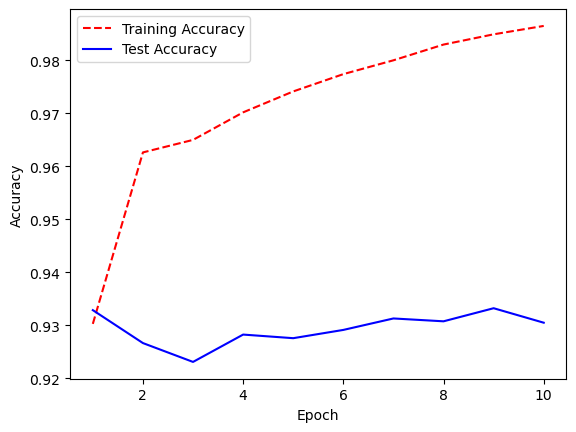

In [111]:
from matplotlib import pyplot as plt
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

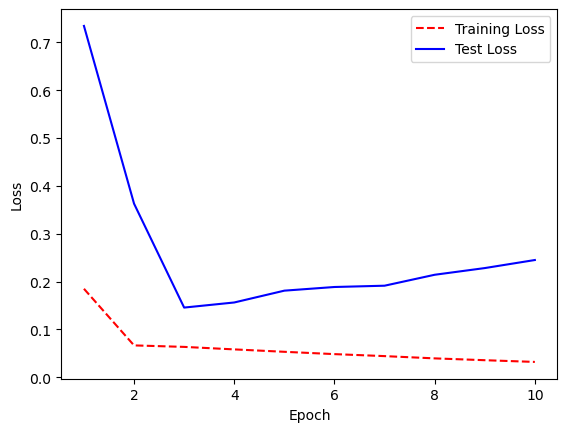

In [112]:
from matplotlib import pyplot as plt
training_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();